# Problem 5

Here we will revisit the phase diagram problem from the logistic regression module. Your task will be to code a one-vs-rest support vector classifier.

Work through this notebook, filling in code as requested, to implement the OvR classifier.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.svm import SVC

x1 = np.array([7.4881350392732475,16.351893663724194,22.427633760716436,29.04883182996897,35.03654799338904,44.45894113066656,6.375872112626925,18.117730007820796,26.036627605010292,27.434415188257777,38.71725038082664,43.28894919752904,7.680445610939323,18.45596638292661,17.110360581978867,24.47129299701541,31.002183974403255,46.32619845547938,9.781567509498505,17.90012148246819,26.186183422327638,31.59158564216724,35.41479362252932,45.805291762864556,3.182744258689332,15.599210213275237,17.833532874090462,33.04668917049584,36.018483217500716,42.146619399905234,4.64555612104627,16.942336894342166,20.961503322165484,29.284339488686488,30.98789800436355,44.17635497075877,])
x2 = np.array([0.11120957227224215,0.1116933996874757,0.14437480785146242,0.11818202991034835,0.0859507900573786,0.09370319537993416,0.2797631195927265,0.216022547162927,0.27667667154456677,0.27706378696181594,0.2310382561073841,0.22289262976548535,0.40154283509241845,0.4063710770942623,0.427019677041788,0.41386015134623205,0.46883738380592266,0.38020448107480287,0.5508876756094834,0.5461309517884996,0.5953108325465398,0.5553291602539782,0.5766310772856306,0.5544425592001603,0.705896958364552,0.7010375141164304,0.7556329589465274,0.7038182951348614,0.7096582361680054,0.7268725170660963,0.9320993229847936,0.8597101275793062,0.9337944907498804,0.8596098407893963,0.9476459465013396,0.8968651201647702,])
X = np.vstack([x1,x2]).T
y = np.array([0,2,2,2,2,2,0,2,2,2,2,2,0,0,2,0,1,2,0,0,1,1,1,2,0,1,0,1,1,1,0,0,1,1,1,1,])


def plot_data(X, y, title="Phase of simulated material", newfig=True):
    xlim = [0,52.5]
    ylim = [0,1.05]
    markers = [dict(marker="o", color="royalblue"), dict(marker="s", color="crimson"), dict(marker="^", color="limegreen")]
    labels = ["Solid", "Liquid", "Vapor"]

    if newfig:
        plt.figure(dpi=150)

    for i in range(1+max(y)):
        plt.scatter(X[y==i,0], X[y==i,1], s=60, **(markers[i]), edgecolor="black", linewidths=0.4,label=labels[i])

    plt.title(title)
    plt.legend(loc="upper right")
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel("Temperature, K")
    plt.ylabel("Pressure, atm")
    plt.box(True)

def plot_ovr_colors(classifiers, res=40):
    xlim = [0,52.5]
    ylim = [0,1.05]
    xvals = np.linspace(*xlim,res)
    yvals = np.linspace(*ylim,res)
    x,y = np.meshgrid(xvals,yvals)
    XY = np.concatenate((x.reshape(-1,1),y.reshape(-1,1)),axis=1)
    if type(classifiers) == list:
        color = classify_ovr(classifiers,XY).reshape(res,res)
    else:
        color = classifiers(XY).reshape(res,res)
    cmap = ListedColormap(["lightblue","lightcoral","palegreen"])
    plt.pcolor(x, y, color, shading="nearest", zorder=-1, cmap=cmap,vmin=0,vmax=2)
    return

## Binomial classification function

You are given a function that performs binomial classification by using sklearn's `SVC` tool:
`prob = get_ovr_decision_function(X, y, A, kernel, C)`

To use it, input:
- `X`, an array in which each row contains (x,y) coordinates of data points
- `y`, an array that specifies the class each point in `X` belongs to
- `A`, the class of the group (0, 1, or 2 in this problem) -- classifies into A or "rest"
- `kernel`, the kernel to use for the SVM
- `C`, the inverse regularization strength to use for the SVM

The function outputs a decision function (`decision()` in this case), which can be used to evaluate each `X`, giving positive values for class A, and negative values for [not A].

In [2]:
def get_ovr_decision_function(X, y, A, kernel="linear",C=1000):
    y_new = -1 + 2*(y == A).astype(int)
    
    model = SVC(kernel=kernel,C=C)
    model.fit(X, y_new)

    def decision(X):
        pred = model.decision_function(X)
        return pred.flatten()
    
    return decision

## Coding an OvR classifier

Now you will create a one-vs-rest classifier to do multinomial classification. This will generate a binomial classifier for each class in the dataset, when compared against the rest of the classes. Then to predict the class of a new point, classify it using each of the binomial classifiers, and select the class whose binomial classifier decision function returns the highest value.

Complete the two functions we have started:
- `generate_ovr_decision_functions(X, y)` which returns a list of binary classifier probability functions for all possible classes (0, 1, and 2 in this problem)
- `classify_ovr(decisions, X)` which loops through a list of ovr classifiers and gets the decision function evaluation for each point in `X`. Then taking the highest decision function value for each, return the overall class predictions for each point.

In [3]:
def generate_ovr_decision_functions(X, y, kernel="linear", C=1000):
    decisions = []
    classes = np.unique(y)
    for A in classes:
        p = get_ovr_decision_function(X, y, A, kernel, C)
        decisions.append(p)
    return decisions

def classify_ovr(decisions, X):
    all_preds = []
    classes = np.unique(y)
    for d in decisions:
        pred = d(X)
        all_preds.append(pred)
    all_preds = np.array(all_preds)

    maj_preds = classes[np.argmax(all_preds, axis=0)]
    return maj_preds

## Testing the classifier

In [4]:
kernel = "linear"
C = 1000

decisions = generate_ovr_decision_functions(X, y, kernel, C)
preds = classify_ovr(decisions, X)
accuracy = np.sum(preds == y) / len(y) * 100
print("True Classes:", y)
print(" Predictions:", preds)
print("    Accuracy:", accuracy, r"%")

True Classes: [0 2 2 2 2 2 0 2 2 2 2 2 0 0 2 0 1 2 0 0 1 1 1 2 0 1 0 1 1 1 0 0 1 1 1 1]
 Predictions: [0 2 2 2 2 2 0 2 2 2 2 2 0 0 0 2 1 2 0 0 1 1 1 2 0 0 0 1 1 1 0 0 1 1 1 1]
    Accuracy: 91.66666666666666 %


### Plotting results

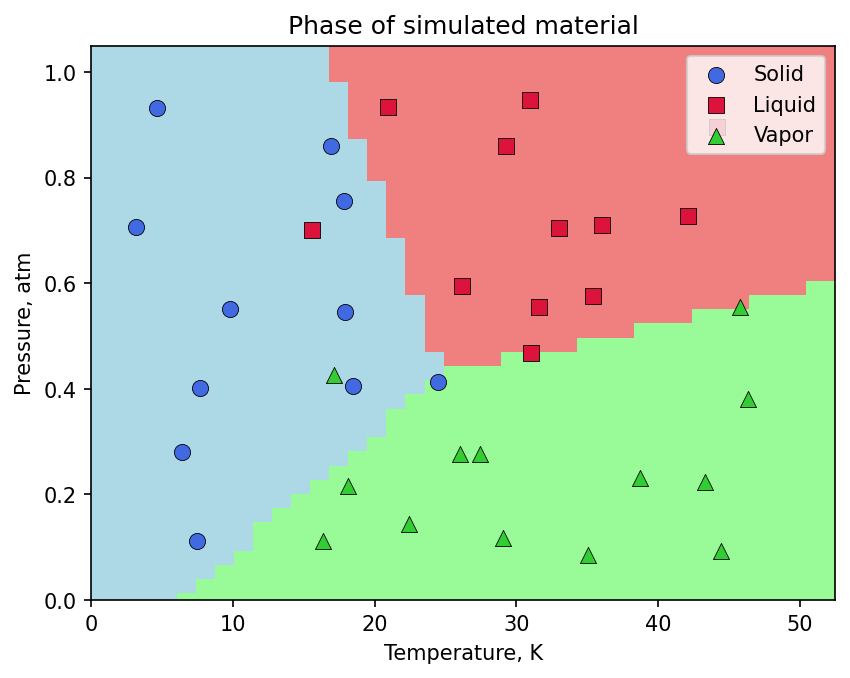

In [5]:
plot_data(X,y)
plot_ovr_colors(decisions)
plt.show()

## Modifying the SVC
Now go back and change the kernel and C value; observe how the results change.

True Classes: [0 2 2 2 2 2 0 2 2 2 2 2 0 0 2 0 1 2 0 0 1 1 1 2 0 1 0 1 1 1 0 0 1 1 1 1]
 Predictions: [0 2 2 2 2 2 0 2 2 2 2 2 0 2 2 0 1 2 0 0 1 1 1 2 0 0 0 1 1 1 0 0 0 1 1 1]
    Accuracy: 91.66666666666666 %


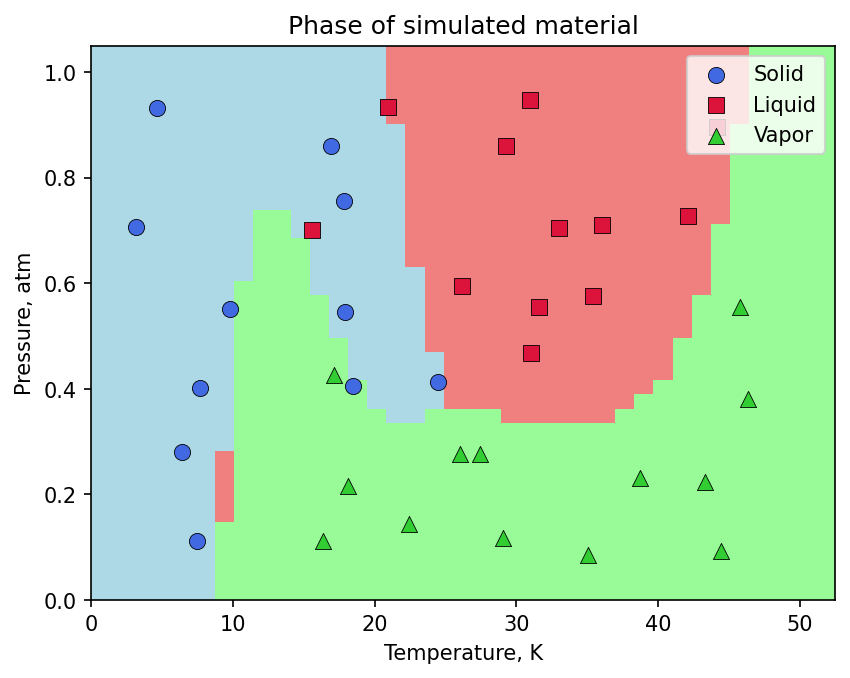

In [7]:
kernel = "rbf"  # CHANGE THIS
C = 100000            # CHANGE THIS

decisions = generate_ovr_decision_functions(X, y, kernel, C)
preds = classify_ovr(decisions, X)
accuracy = np.sum(preds == y) / len(y) * 100
print("True Classes:", y)
print(" Predictions:", preds)
print("    Accuracy:", accuracy, r"%")

plot_data(X,y)
plot_ovr_colors(decisions)
plt.show()